In [1]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [58]:
import os
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [59]:
df = pd.read_csv('Mall_Customers.csv')

In [60]:
df.shape

(200, 5)

In [61]:
df = df.rename(columns={"Genre": "Gender"})

In [62]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [63]:
print(df.describe(include="all").transpose())

                        count unique     top freq   mean        std   min  \
CustomerID              200.0    NaN     NaN  NaN  100.5  57.879185   1.0   
Gender                    200      2  Female  112    NaN        NaN   NaN   
Age                     200.0    NaN     NaN  NaN  38.85  13.969007  18.0   
Annual Income (k$)      200.0    NaN     NaN  NaN  60.56  26.264721  15.0   
Spending Score (1-100)  200.0    NaN     NaN  NaN   50.2  25.823522   1.0   

                          25%    50%     75%    max  
CustomerID              50.75  100.5  150.25  200.0  
Gender                    NaN    NaN     NaN    NaN  
Age                     28.75   36.0    49.0   70.0  
Annual Income (k$)       41.5   61.5    78.0  137.0  
Spending Score (1-100)  34.75   50.0    73.0   99.0  


In [64]:
# ================================
# PREPROCESSING THE DATASET
# ================================
# Normalize column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

In [65]:
# Basic cleaning
# (If ID column exists, keep for reference but not for clustering)
id_col = None
for c in df.columns:
    if c.lower() in ["customerid", "customer_id", "id"]:
        id_col = c
        break

In [66]:
# Missing values overview
print("Missing values per column:\n", df.isna().sum())


Missing values per column:
 CustomerID                0
Gender                    0
Age                       0
Annual_Income_(k$)        0
Spending_Score_(1-100)    0
dtype: int64


In [67]:
# EXPLORATORY DATA ANALYSIS

In [13]:
# Categorical distributions (Gender)
if "Gender" in df.columns:
    gender_counts = df["Gender"].value_counts(dropna=False)
    plt.figure()
    plt.bar(gender_counts.index.astype(str), gender_counts.values)
    plt.title("Gender Distribution")
    plt.xlabel("Gender"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()


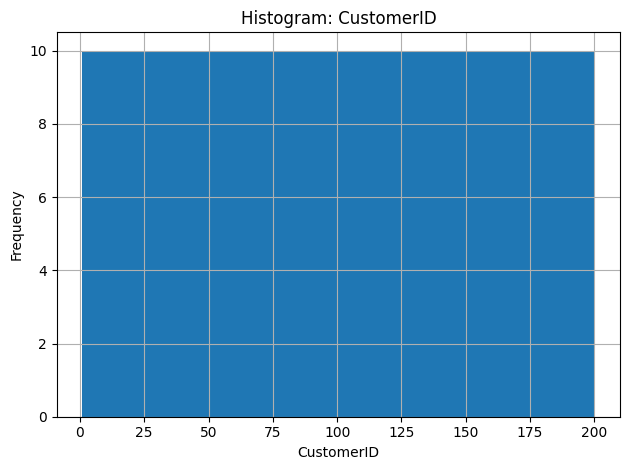

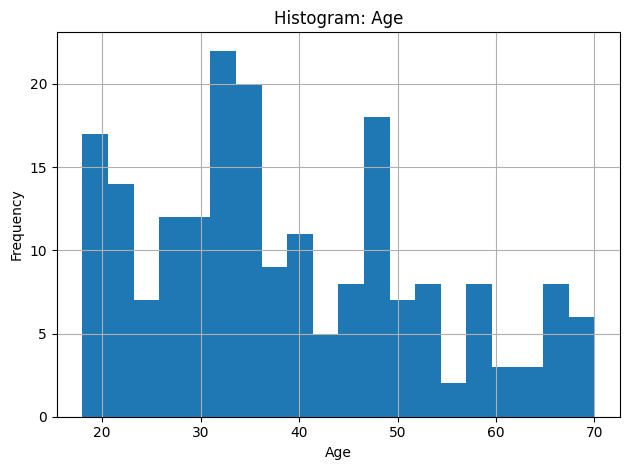

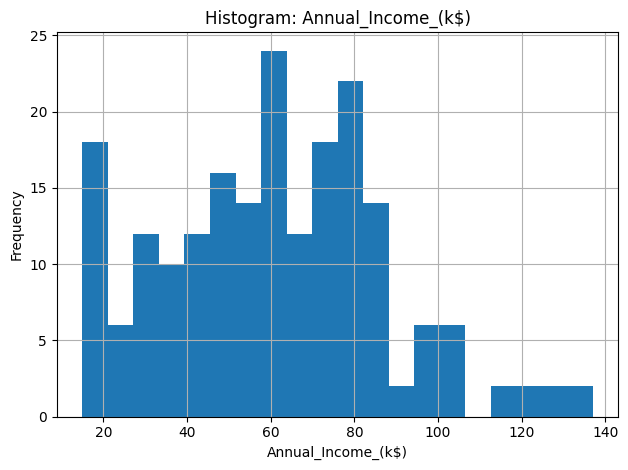

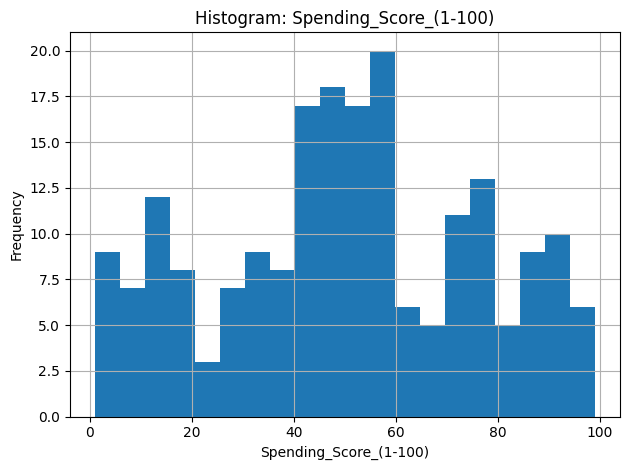

In [68]:
# 4.2 Histograms for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    plt.figure()
    df[col].hist(bins=20)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

<Figure size 640x480 with 0 Axes>

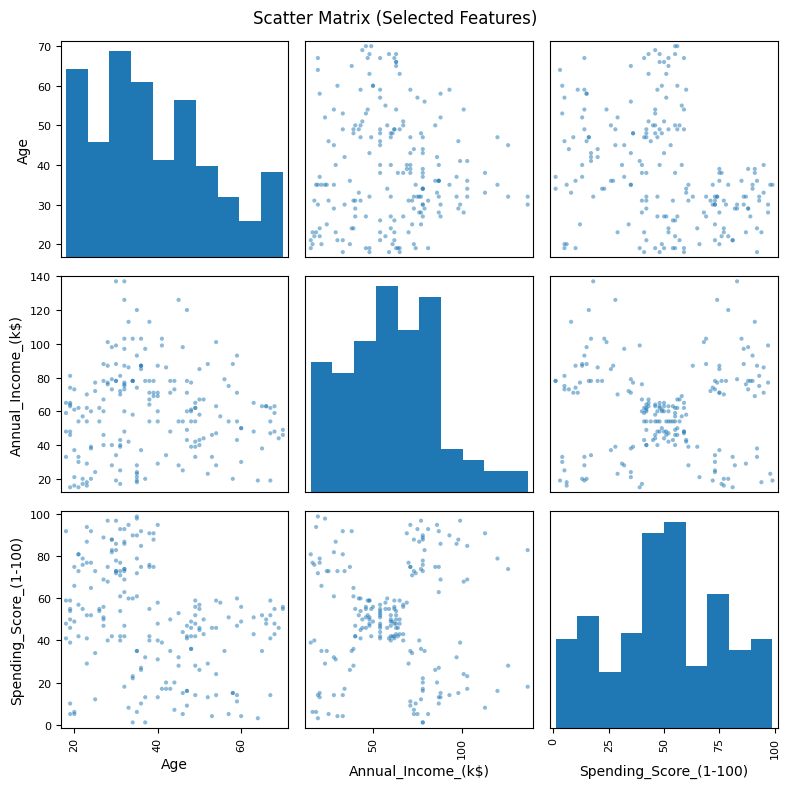

In [69]:
# Scatter matrix for selected features (guard for errors)
scatter_candidates = [c for c in ["Age", "Annual_Income_(k$)", "Spending_Score_(1-100)"] if c in df.columns]
try:
    if len(scatter_candidates) >= 2:
        plt.figure()
        sm = scatter_matrix(df[scatter_candidates], figsize=(8, 8), diagonal='hist')
        plt.suptitle("Scatter Matrix (Selected Features)")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Scatter matrix skipped due to:", e)

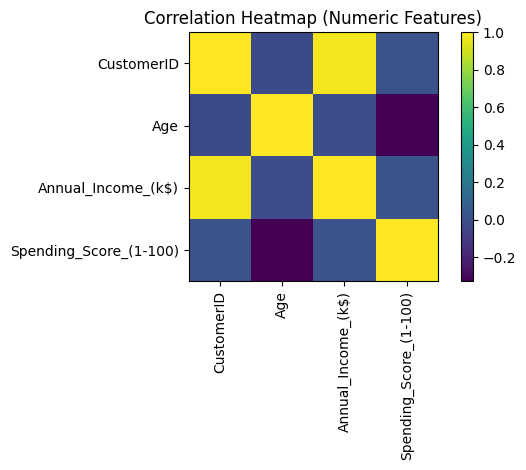

In [70]:
# Correlation heatmap (numeric features)
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout(); plt.show()

In [83]:
                                                       # ================================
                                                       #       FEATURE ENGINEERING
                                                       # ================================

if "Gender" in df.columns:
    df["Gender_Encoded"] = df["Gender"].map({"Male": 1, "Female": 0})

#  Create ratios / interactions (common choices for this dataset)
if all(c in df.columns for c in ["Annual_Income_(k$)", "Age"]):
    df["Income_per_Age"] = df["Annual_Income_(k$)"] / df["Age"].replace(0, np.nan)

if all(c in df.columns for c in ["Spending_Score_(1-100)", "Annual_Income_(k$)"]):
    df["Spending_per_Income"] = df["Spending_Score_(1-100)"] / df["Annual_Income_(k$)"].replace(0, np.nan)

if all(c in df.columns for c in ["Age", "Spending_Score_(1-100)"]):
    df["Age_x_Spending"] = df["Age"] * df["Spending_Score_(1-100)"]

# Age bins for profiling (not used in modeling)
if "Age" in df.columns:
    df["Age_Bin"] = pd.cut(df["Age"], bins=[0, 25, 35, 50, 100], labels=["<=25", "26-35", "36-50", "50+"])

In [162]:
# ================================
# MODELING PREP (Select Features + Scale)
# ================================
feature_candidates = [
    "Gender"
    "Age",
    "Annual_Income_(k$)",
    "Spending_Score_(1-100)",
    # "Income_per_Age",
    # "Spending_per_Income",
    # "Age_x_Spending",
]

X_cols = [c for c in feature_candidates if c in df.columns]
X = df[X_cols].copy()

In [163]:
# Handle inf/nan from divisions
X = X.replace([np.inf, -np.inf], np.nan)
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features used:", X_cols)


Features used: ['Annual_Income_(k$)', 'Spending_Score_(1-100)']


In [164]:
# ================================
# 7) CHOOSE K (Elbow + Silhouette)
# ================================
inertias, sil_scores = [], []
K_range = list(range(2, 11))

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

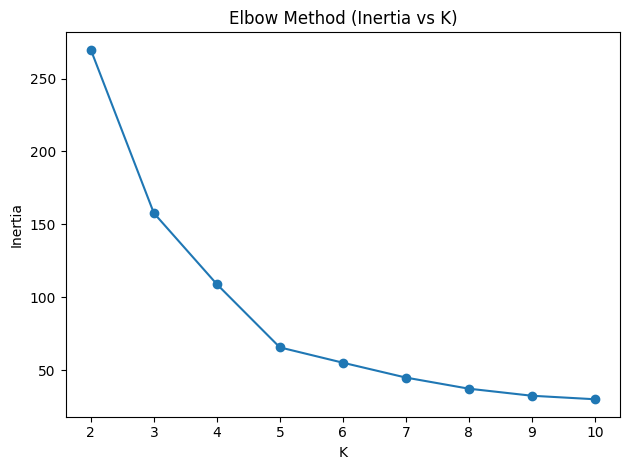

In [165]:
# Plot Elbow
plt.figure()
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K"); plt.ylabel("Inertia")
plt.xticks(K_range)
plt.tight_layout(); plt.show()

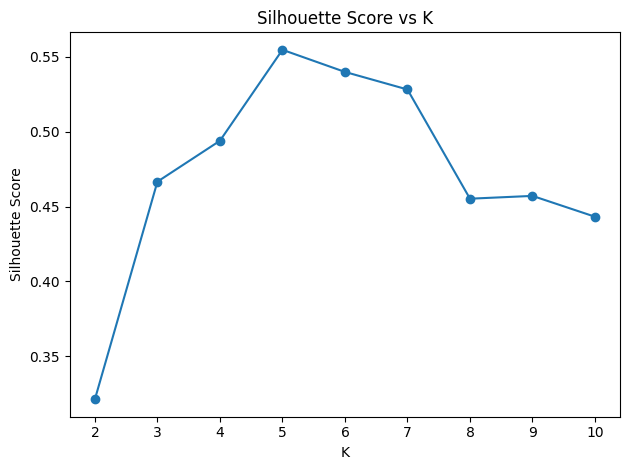

In [166]:
# Plot Silhouette
plt.figure()
plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Score vs K")
plt.xlabel("K"); plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.tight_layout(); plt.show()

In [167]:
# Choose K by best silhouette
best_k = K_range[int(np.argmax(sil_scores))]
print("Best K (by silhouette):", best_k)

Best K (by silhouette): 5


In [168]:
# ================================
# FINAL MODEL (KMeans)
# ================================
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df["Cluster"] = cluster_labels


In [169]:
sil_final = silhouette_score(X_scaled, cluster_labels)
db_final = davies_bouldin_score(X_scaled, cluster_labels)
print("Final Silhouette:", sil_final)
print("Final Davies-Bouldin:", db_final)

Final Silhouette: 0.5546571631111091
Final Davies-Bouldin: 0.5722356162263352


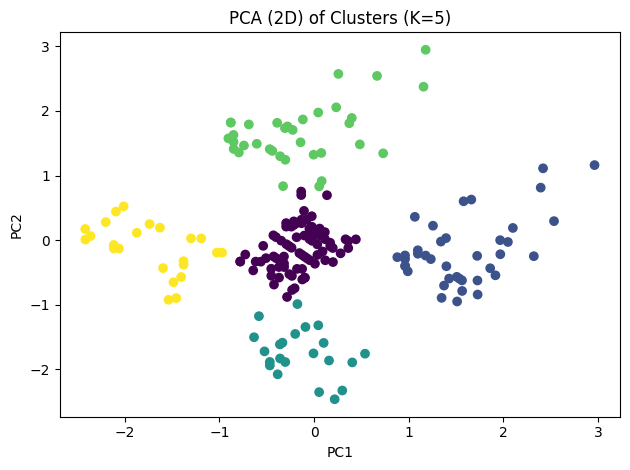

In [170]:
# ================================
#  PCA 2D VISUALIZATION
# ================================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title(f"PCA (2D) of Clusters (K={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

In [171]:
# ================================
# CLUSTER PROFILING
# ================================
profile_cols = []
if id_col: profile_cols.append(id_col)
profile_cols += X_cols + ["Cluster"]
prof = df[profile_cols].groupby("Cluster")[X_cols].agg(["count", "mean", "median"])
print(prof)

# Distribution of clusters by Gender / Age_Bin if available
if "Gender" in df.columns:
    print("Cluster × Gender:")
    print(df.groupby(["Cluster", "Gender"]).size().unstack(fill_value=0))

if "Age_Bin" in df.columns:
    print("Cluster × Age_Bin:")
    print(df.groupby(["Cluster", "Age_Bin"]).size().unstack(fill_value=0))


        Annual_Income_(k$)                   Spending_Score_(1-100)  \
                     count       mean median                  count   
Cluster                                                               
0                       81  55.296296   54.0                     81   
1                       39  86.538462   79.0                     39   
2                       22  25.727273   24.5                     22   
3                       35  88.200000   85.0                     35   
4                       23  26.304348   25.0                     23   

                           
              mean median  
Cluster                    
0        49.518519   50.0  
1        82.128205   83.0  
2        79.363636   77.0  
3        17.114286   16.0  
4        20.913043   17.0  
Cluster × Gender:
Gender   Female  Male
Cluster              
0            48    33
1            21    18
2            13     9
3            16    19
4            14     9
Cluster × Age_Bin:
Age_Bin  <=25  2

/tmp/ipython-input-1478518498.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(["Cluster", "Age_Bin"]).size().unstack(fill_value=0))
